In [2]:
import tensorflow as tf
tf.__version__

'1.15.0'

In [3]:
"""
@author: Maziar Raissi
"""

import sys
sys.path.insert(0, '../../Utilities/')

import tensorflow as tf
import numpy as np
##import matplotlib.pyplot as plt
import scipy.io
from scipy.interpolate import griddata
from pyDOE import lhs
##from plotting import newfig, savefig
from mpl_toolkits.mplot3d import Axes3D
import time
##import matplotlib.gridspec as gridspec
##from mpl_toolkits.axes_grid1 import make_axes_locatable

np.random.seed(1234)
tf.set_random_seed(1234)

In [4]:
class PhysicsInformedNN:
    # Initialize the class
    def __init__(self, X_p, p, X_f, layers, lb, ub, alpha):
        
        self.lb = lb
        self.ub = ub 
    
        self.X_p = X_p[:,0:1]
        self.t_p = X_p[:,1:2]
        
        self.x_f = X_f[:,0:1]
        self.t_f = X_f[:,1:2]
        
        self.p = p
        
        self.layers = layers
        self.alpha= alpha
        
        # Initialize NNs
        self.weights, self.biases = self.initialize_NN(layers)
        
        # tf placeholders and graph
        self.sess = tf.Session(config=tf.ConfigProto(allow_soft_placement=True,
                                                     log_device_placement=True)) ##tf.ConfigProto
        
        self.X_p_tf = tf.placeholder(tf.float32, shape=[None, self.X_p.shape[1]])
        self.t_p_tf = tf.placeholder(tf.float32, shape=[None, self.t_p.shape[1]])        
        self.p_tf = tf.placeholder(tf.float32, shape=[None, self.p.shape[1]])
        
        self.x_f_tf = tf.placeholder(tf.float32, shape=[None, self.x_f.shape[1]])
        self.t_f_tf = tf.placeholder(tf.float32, shape=[None, self.t_f.shape[1]])        
                
        self.p_pred = self.net_p(self.X_p_tf, self.t_p_tf) 
        self.f_pred = self.net_f(self.x_f_tf, self.t_f_tf)         
        
        self.loss = tf.reduce_mean(tf.square(self.p_tf - self.p_pred)) +  tf.reduce_mean(tf.square(self.f_pred))
               
                
        self.optimizer = tf.contrib.opt.ScipyOptimizerInterface(self.loss, 
                                                                method = 'L-BFGS-B', 
                                                                options = {'maxiter': 50000,
                                                                           'maxfun': 50000,
                                                                           'maxcor': 50,
                                                                           'maxls': 50,
                                                                           'ftol' : 1.0 * np.finfo(float).eps})
        
        init = tf.global_variables_initializer()
        self.sess.run(init)

                
    def initialize_NN(self, layers):        
        weights = []
        biases = []
        num_layers = len(layers) 
        for l in range(0,num_layers-1):
            W = self.xavier_init(size=[layers[l], layers[l+1]])
            b = tf.Variable(tf.zeros([1,layers[l+1]], dtype=tf.float32), dtype=tf.float32) ##??
            weights.append(W)
            biases.append(b)        
        return weights, biases
        
    def xavier_init(self, size):
        in_dim = size[0]
        out_dim = size[1]        
        xavier_stddev = np.sqrt(2/(in_dim + out_dim))
        return tf.Variable(tf.truncated_normal([in_dim, out_dim], stddev=xavier_stddev), dtype=tf.float32)
    
    def neural_net(self, X, weights, biases):
        num_layers = len(weights) + 1
        
        H = 2.0*(X - self.lb)/(self.ub - self.lb) - 1.0 
        for l in range(0,num_layers-2):
            W = weights[l]
            b = biases[l]
            H = tf.tanh(tf.add(tf.matmul(H, W), b))   ##Activation Function
        W = weights[-1]
        b = biases[-1]
        Y = tf.add(tf.matmul(H, W), b)
        return Y
            
    def net_p(self, x, t):
        p = self.neural_net(tf.concat([x,t],1), self.weights, self.biases)
        return p
    
#Acoustic Equation

    def net_f(self, x,t):
        p = self.net_p(x,t)
        p_t = tf.gradients(p, t)[0]
        p_x = tf.gradients(p, x)[0]
        p_tt = tf.gradients(p_t, t)[0]
        p_xx = tf.gradients(p_x, x)[0]
#         f = u_t + u*u_x - self.nu*u_xx
        c0=1
        f = (c0**2)*p_xx - p_tt - self.alpha*p_t       # f = u_t + u*u_x - self.nu*u_xx

        return f
    def callback(self, loss):
        print('Loss:', loss)
        
    def train(self):
        
        tf_dict = {self.X_p_tf: self.X_p, self.t_p_tf: self.t_p, self.p_tf: self.p,
                   self.x_f_tf: self.x_f, self.t_f_tf: self.t_f}
                                                                                                                          
        self.optimizer.minimize(self.sess, 
                                feed_dict = tf_dict,         
                                fetches = [self.loss], 
                                loss_callback = self.callback)        
                                    
    
    def predict(self, X_star):
                
        p_star = self.sess.run(self.p_pred, {self.X_p_tf: X_star[:,0:1], self.t_p_tf: X_star[:,1:2]})  
        f_star = self.sess.run(self.f_pred, {self.x_f_tf: X_star[:,0:1], self.t_f_tf: X_star[:,1:2]})
               
        return p_star, f_star
    

    
    

In [ ]:
if __name__ == "__main__": 
     
#     nu= 0.01/np.pi
    alpha1= 0
    noise = 0.0        

    N_p = 100
    N_f = 10000
    layers = [2, 10, 10,  1]
    
    data = scipy.io.loadmat('Training_Dataset.mat')
    
    t = data['t'].flatten()[:,None]
    x = data['x'].flatten()[:,None]
    Exact = np.real(data['p']).T
    
    X, T = np.meshgrid(x,t)
    
    X_star = np.hstack((X.flatten()[:,None], T.flatten()[:,None]))
    p_star = Exact.flatten()[:,None]              

    # Doman bounds
    lb = X_star.min(0)
    ub = X_star.max(0)    
        
    xx1 = np.hstack((X[0:1,:].T, T[0:1,:].T))
    pp1 = Exact[0:1,:].T
    xx2 = np.hstack((X[:,0:1], T[:,0:1]))
    pp2 = Exact[:,0:1]
    xx3 = np.hstack((X[:,-1:], T[:,-1:]))
    pp3 = Exact[:,-1:]
    
    X_p_train = np.vstack([xx1, xx2, xx3])
    X_f_train = lb + (ub-lb)*lhs(2, N_f)
    X_f_train = np.vstack((X_f_train, X_p_train))
    p_train = np.vstack([pp1, pp2, pp3])
    
    idx = np.random.choice(X_p_train.shape[0], N_p, replace=False)
    X_p_train = X_p_train[idx, :]
    p_train = p_train[idx,:]
        
    model = PhysicsInformedNN(X_p_train, p_train, X_f_train, layers, lb, ub, alpha1)
    
    start_time = time.time()                
    model.train()
    elapsed = time.time() - start_time                
    print('Training time: %.4f' % (elapsed))
    
    p_pred, f_pred = model.predict(X_star)
            
    error_p = np.linalg.norm(p_star-p_pred,2)/np.linalg.norm(p_star,2)
    print('Error p: %e' % (error_p))                     

    
    P_pred = griddata(X_star, p_pred.flatten(), (X, T), method='cubic')
    Error = np.abs(Exact - P_pred)

Device mapping:

The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Loss: 0.0743394
Loss: 0.4257912
Loss: 0.07238527
Loss: 0.045952838
Loss: 0.038383923
Loss: 0.03370832
Loss: 0.030537805
Loss: 0.02626543
Loss: 0.030767411
Loss: 0.02545065
Loss: 0.025250025
Loss: 0.025145806
Loss: 0.025090983
Loss: 0.025024157
Loss: 0.024926703
Loss: 0.024772255
Loss: 0.024404569
Loss: 0.02408165
Loss: 0.023544246
Loss: 0.02245519
Loss: 0.022582423
Loss: 0.022148175
Loss: 0.021798594
Loss: 0.021620331
Loss: 0.021486439
Loss: 0.021363357
Loss: 0.021253234
Loss: 0.021122314
Loss: 0.021023631
Loss: 0.020943169
Loss: 0.020901287
Loss: 0.020875854
Loss: 0.020848872
Loss: 0.020822763
Loss: 0.02078859


Loss: 0.010198146
Loss: 0.010110243
Loss: 0.010108549
Loss: 0.010081417
Loss: 0.010142916
Loss: 0.010066691
Loss: 0.010042394
Loss: 0.010027012
Loss: 0.01000713
Loss: 0.009990679
Loss: 0.009980127
Loss: 0.009973326
Loss: 0.009966989
Loss: 0.009963905
Loss: 0.009955808
Loss: 0.009951665
Loss: 0.009943406
Loss: 0.009935575
Loss: 0.009925357
Loss: 0.00991759
Loss: 0.009918878
Loss: 0.009905876
Loss: 0.009890078
Loss: 0.009860065
Loss: 0.009848205
Loss: 0.009831833
Loss: 0.009811914
Loss: 0.009772468
Loss: 0.009763125
Loss: 0.009754321
Loss: 0.009748652
Loss: 0.009739352
Loss: 0.009719013
Loss: 0.009699521
Loss: 0.009696887
Loss: 0.009685518
Loss: 0.009660273
Loss: 0.009633621
Loss: 0.009612804
Loss: 0.009638413
Loss: 0.009605748
Loss: 0.0095992815
Loss: 0.0095926495
Loss: 0.009587694
Loss: 0.009580433
Loss: 0.0095650945
Loss: 0.009559974
Loss: 0.009553977
Loss: 0.00954574
Loss: 0.009538345
Loss: 0.009532448
Loss: 0.009531451
Loss: 0.009530368
Loss: 0.009529321
Loss: 0.009528577
Loss: 0.00

Loss: 0.0077222846
Loss: 0.0077194064
Loss: 0.0077186828
Loss: 0.007717469
Loss: 0.007716612
Loss: 0.0077147055
Loss: 0.0077135507
Loss: 0.0077121384
Loss: 0.0077108527
Loss: 0.0077099535
Loss: 0.0077088242
Loss: 0.0077075353
Loss: 0.007706645
Loss: 0.0077056456
Loss: 0.007704586
Loss: 0.0077035357
Loss: 0.007702045
Loss: 0.0077001117
Loss: 0.0076983795
Loss: 0.0076965815
Loss: 0.0076936423
Loss: 0.007685338
Loss: 0.007675969
Loss: 0.0076635634
Loss: 0.0076449937
Loss: 0.0076303394
Loss: 0.0076323403
Loss: 0.0076241833
Loss: 0.0076217456
Loss: 0.0076200073
Loss: 0.007616358
Loss: 0.0076127993
Loss: 0.0076103075
Loss: 0.007606204
Loss: 0.0076018022
Loss: 0.0075996662
Loss: 0.0075978125
Loss: 0.0075958087
Loss: 0.0075937677
Loss: 0.007592326
Loss: 0.0075917672
Loss: 0.007591359
Loss: 0.007591086
Loss: 0.007590694
Loss: 0.0075900294
Loss: 0.0075899605
Loss: 0.0075894897
Loss: 0.007588448
Loss: 0.007587483
Loss: 0.0075864517
Loss: 0.0075859255
Loss: 0.0075849644
Loss: 0.0075839213
Loss: 0.

Loss: 0.0065334514
Loss: 0.0065284
Loss: 0.006527561
Loss: 0.0065266383
Loss: 0.006525982
Loss: 0.006525186
Loss: 0.006524875
Loss: 0.006524476
Loss: 0.0065241153
Loss: 0.0065237205
Loss: 0.0065231025
Loss: 0.006522224
Loss: 0.0065208366
Loss: 0.0065187993
Loss: 0.0065164496
Loss: 0.006514616
Loss: 0.006513327
Loss: 0.006512229
Loss: 0.006511075
Loss: 0.006510243
Loss: 0.0065098437
Loss: 0.00650942
Loss: 0.006509203
Loss: 0.006508978
Loss: 0.0065087443
Loss: 0.0065089925
Loss: 0.0065086912
Loss: 0.006508591
Loss: 0.0065085297
Loss: 0.0065083434
Loss: 0.0065080347
Loss: 0.006507736
Loss: 0.0065074787
Loss: 0.0065072025
Loss: 0.0065068738
Loss: 0.0065065916
Loss: 0.006506391
Loss: 0.006506471
Loss: 0.0065062577
Loss: 0.0065061143
Loss: 0.0065059387
Loss: 0.0065056924
Loss: 0.006507033
Loss: 0.0065055955
Loss: 0.0065052384
Loss: 0.006504648
Loss: 0.0065036197
Loss: 0.006502042
Loss: 0.0064996914
Loss: 0.006504477
Loss: 0.0064984295
Loss: 0.0064948434
Loss: 0.0064885085
Loss: 0.0064832508


Loss: 0.0061716707
Loss: 0.0061702896
Loss: 0.0061689736
Loss: 0.0061677713
Loss: 0.0061663166
Loss: 0.0061652763
Loss: 0.006166023
Loss: 0.0061644316
Loss: 0.0061642765
Loss: 0.0061636507
Loss: 0.0061631068
Loss: 0.006162484
Loss: 0.0061617834
Loss: 0.006160698
Loss: 0.0061591775
Loss: 0.006160417
Loss: 0.0061583766
Loss: 0.006157439
Loss: 0.0061581084
Loss: 0.006156812
Loss: 0.006156461
Loss: 0.006156239
Loss: 0.006155949
Loss: 0.006155737
Loss: 0.0061554923
Loss: 0.006155185
Loss: 0.006154823
Loss: 0.0061546634
Loss: 0.0061544525
Loss: 0.006154246
Loss: 0.006154076
Loss: 0.0061539356
Loss: 0.006153718
Loss: 0.0061535914
Loss: 0.0061533847
Loss: 0.006153282
Loss: 0.006153183
Loss: 0.0061530834
Loss: 0.0061528916
Loss: 0.0061527127
Loss: 0.006152495
Loss: 0.0061521847
Loss: 0.0061519346
Loss: 0.0061515644
Loss: 0.006151232
Loss: 0.0061510913
Loss: 0.0061509395
Loss: 0.006150801
Loss: 0.0061507337
Loss: 0.0061506606
Loss: 0.006150642
Loss: 0.0061505693
Loss: 0.006150488
Loss: 0.0061503

Loss: 0.0060204645
Loss: 0.0060195248
Loss: 0.0060181194
Loss: 0.00601747
Loss: 0.006016594
Loss: 0.0060160384
Loss: 0.0060155448
Loss: 0.006014715
Loss: 0.006014213
Loss: 0.006013806
Loss: 0.0060131866
Loss: 0.0060125366
Loss: 0.0060115936
Loss: 0.006010805
Loss: 0.0060101235
Loss: 0.0060093547
Loss: 0.006008283
Loss: 0.00600748
Loss: 0.00600688
Loss: 0.0060065347
Loss: 0.0060061864
Loss: 0.00600592
Loss: 0.0060057547
Loss: 0.006005603
Loss: 0.0060054576
Loss: 0.0060052895
Loss: 0.006005053
Loss: 0.0060047964
Loss: 0.0060045337
Loss: 0.006004219
Loss: 0.0060037794
Loss: 0.0060042744
Loss: 0.0060036154
Loss: 0.0060032434
Loss: 0.006002429
Loss: 0.0060020266
Loss: 0.0060016904
Loss: 0.006001439
Loss: 0.006001001
Loss: 0.0060006287
Loss: 0.0060002934
Loss: 0.006001924
Loss: 0.0060002035
Loss: 0.0060000075
Loss: 0.0059997877
Loss: 0.005999507
Loss: 0.005999136
Loss: 0.0059986985
Loss: 0.005997898
Loss: 0.00599576
Loss: 0.005994571
Loss: 0.005993382
Loss: 0.0059925714
Loss: 0.0059921634
Lo

findfont: Font family ['serif'] not found. Falling back to DejaVu Sans.


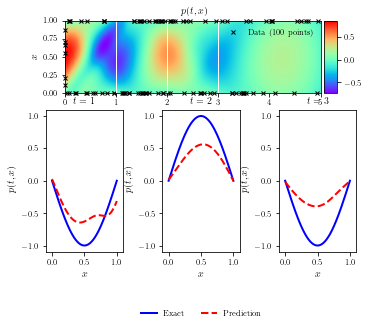

In [4]:
######################################################################
    ############################# Plotting ###############################
    ######################################################################    
    
    fig, ax = newfig(1.0, 1.1)
    ax.axis('off')
    
    ####### Row 0: u(t,x) ##################    
    gs0 = gridspec.GridSpec(1, 2)
    gs0.update(top=1-0.06, bottom=1-1/3, left=0.15, right=0.85, wspace=0)
    ax = plt.subplot(gs0[:, :])
    
    h = ax.imshow(P_pred.T, interpolation='nearest', cmap='rainbow', 
                  extent=[t.min(), t.max(), x.min(), x.max()], 
                  origin='lower', aspect='auto')
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)
    fig.colorbar(h, cax=cax)
    
    ax.plot(X_p_train[:,1], X_p_train[:,0], 'kx', label = 'Data (%d points)' % (p_train.shape[0]), markersize = 4, clip_on = False)
    
    line = np.linspace(x.min(), x.max(), 2)[:,None]
    ax.plot(t[1000]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[2000]*np.ones((2,1)), line, 'w-', linewidth = 1)
    ax.plot(t[3000]*np.ones((2,1)), line, 'w-', linewidth = 1)    
    
    ax.set_xlabel('$t$')
    ax.set_ylabel('$x$')
    ax.legend(frameon=False, loc = 'best')
    ax.set_title('$p(t,x)$', fontsize = 10)
    
    ####### Row 1: u(t,x) slices ##################    
    gs1 = gridspec.GridSpec(1, 3)
    gs1.update(top=1-1/3, bottom=0, left=0.1, right=0.9, wspace=0.5)
    
    ax = plt.subplot(gs1[0, 0])
    ax.plot(x,Exact[1000,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,P_pred[1000,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(t,x)$')    
    ax.set_title('$t = 1$', fontsize = 10)
    ax.axis('square')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-1.1,1.1])
    
    ax = plt.subplot(gs1[0, 1])
    ax.plot(x,Exact[2000,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,P_pred[2000,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(t,x)$')
    ax.axis('square')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-1.1,1.1])
    ax.set_title('$t = 2$', fontsize = 10)
    ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.35), ncol=5, frameon=False)
    
    ax = plt.subplot(gs1[0, 2])
    ax.plot(x,Exact[3000,:], 'b-', linewidth = 2, label = 'Exact')       
    ax.plot(x,P_pred[3000,:], 'r--', linewidth = 2, label = 'Prediction')
    ax.set_xlabel('$x$')
    ax.set_ylabel('$p(t,x)$')
    ax.axis('square')
    ax.set_xlim([-0.1,1.1])
    ax.set_ylim([-1.1,1.1])    
    ax.set_title('$t = 3$', fontsize = 10)
    
    savefig('N10_L/Wave_L2_N10_a0')

# Change file name in the code below while saving

In [5]:
x_val=data['x']
t_val=data['t']
np.savetxt('N10_L/P_t5_L2_N10_a0',P_pred)
np.savetxt('N10_L/x_t5_L2_N10_a0',x_val)
np.savetxt('N10_L/t_t5_L2_N10_a0',t_val)